In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [2]:
# Load dataset
df = pd.read_csv("readyForModeling.csv")
df.head()


,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,cuaca
0,24.3,33.2,27.1,90.0,1.9,2.8,4.0,300.0,1.0,4,2
1,24.3,29.8,26.5,91.0,24.3,2.7,3.0,130.0,0.0,8,2
2,24.0,34.0,27.9,86.0,3.4,0.4,3.0,70.0,1.0,8,2
3,24.2,34.2,28.4,82.0,0.0,4.2,3.0,300.0,1.0,8,1
4,24.2,32.2,27.4,88.0,0.0,7.7,4.0,280.0,1.0,8,1


In [3]:
# Pisahkan fitur dan target
X = df.drop(columns=["cuaca"])
y = df["cuaca"]


In [4]:
# Tentukan fitur numerik dan kategorikal
numeric_features = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg']
categorical_features = ['ddd_car']

# Pipeline numerik
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline kategorikal
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Gabung preprocessing
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [5]:
# Pipeline lengkap dengan SMOTE
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


In [6]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_macro')
print("F1 Macro Scores (CV):", scores)
print("Mean F1 Macro:", scores.mean())


F1 Macro Scores (CV): [1.         1.         1.         0.65333333 0.81944444]
Mean F1 Macro: 0.8945555555555555


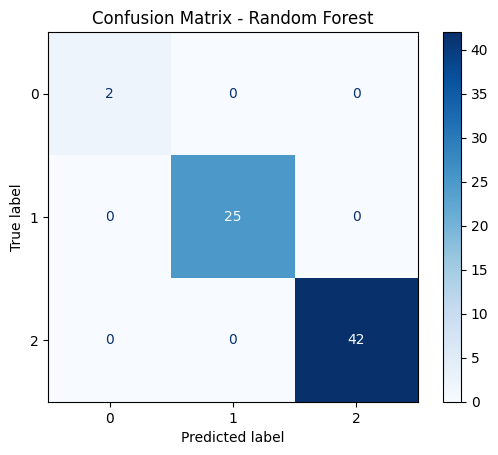

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        42

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [7]:
# Split untuk evaluasi akhir
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Fit model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Laporan klasifikasi
print(classification_report(y_test, y_pred))


## 📌 Penjelasan Ilmiah & Best Practice

1. **Pipeline** digunakan untuk memastikan **tidak terjadi data leakage** — semua preprocessing (imputasi, scaling, encoding) dilakukan di dalam pipeline yang hanya dilatih di training data.
2. **SMOTE** digunakan untuk mengatasi **class imbalance**. SMOTE ditaruh setelah preprocessing agar bekerja di ruang fitur tertransformasi.
3. **Cross-validation (StratifiedKFold)** digunakan agar pembagian data tetap menjaga proporsi kelas (stratifikasi), dan hasil evaluasi lebih stabil.
4. **RandomForest** digunakan dengan `class_weight='balanced'` untuk memperhatikan kelas minoritas, menambah robustness terhadap ketidakseimbangan.
5. Evaluasi akhir dilakukan di test set dengan **Confusion Matrix** dan **Classification Report** agar bisa melihat per kelas.
